In [1]:
# import libraries
import json
import math
import os
from glob import glob 
from tqdm import tqdm
from PIL import Image
import cv2 # image processing
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization


from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split

from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.applications import VGG19
from keras.utils.np_utils import to_categorical
from keras.layers import  Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator,image,img_to_array,load_img

Using TensorFlow backend.


In [2]:
input_dir = "../input/chest-xray-pneumonia/chest_xray/"
train_dir = input_dir +"train/"
test_dir = input_dir +"test/"
val_dir = input_dir +"val/"

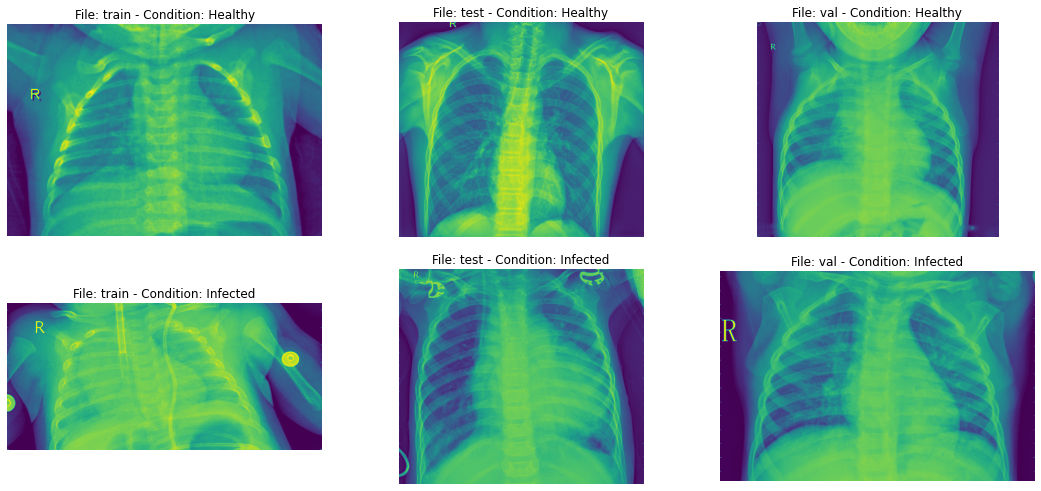

In [3]:
fig, ax = plt.subplots(2,3, figsize=(15,7))
ax = ax.ravel()
plt.tight_layout()
for i, _set in enumerate(['train','test','val']):
    set_path = input_dir+_set
    ax[i].axis('off')
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]))
    ax[i].set_title('File: {} - Condition: Healthy'.format(_set))
    ax[i+3].axis('off')
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]))
    ax[i+3].set_title('File: {} - Condition: Infected'.format(_set))

In [4]:
# Data Augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [5]:
# Create VGG19 Model with Keras library

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(Flatten())
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation="sigmoid"))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['acc']
    )
    return model

vgg19 = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

model = build_model(vgg19 ,lr = 1e-4)
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              33558528  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_______________________________________________________

In [6]:
# Fit Model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=25,
    validation_data=test_generator,
    validation_steps=10
)

Epoch 1/25
100/100 [==============================] - 48s 478ms/step - loss: 0.4943 - acc: 0.7550 - val_loss: 0.4306 - val_acc: 0.6850
Epoch 2/25
100/100 [==============================] - 43s 425ms/step - loss: 0.3284 - acc: 0.8355 - val_loss: 0.3968 - val_acc: 0.8350
Epoch 3/25
100/100 [==============================] - 42s 424ms/step - loss: 0.3006 - acc: 0.8637 - val_loss: 0.3704 - val_acc: 0.8800
Epoch 4/25
100/100 [==============================] - 43s 425ms/step - loss: 0.2874 - acc: 0.8875 - val_loss: 0.7890 - val_acc: 0.8696
Epoch 5/25
100/100 [==============================] - 40s 399ms/step - loss: 0.2270 - acc: 0.9050 - val_loss: 0.8348 - val_acc: 0.8650
Epoch 6/25
100/100 [==============================] - 42s 425ms/step - loss: 0.2273 - acc: 0.9128 - val_loss: 0.1251 - val_acc: 0.8600
Epoch 7/25
100/100 [==============================] - 42s 423ms/step - loss: 0.2152 - acc: 0.9070 - val_loss: 0.3675 - val_acc: 0.9185
Epoch 8/25
100/100 [==============================] - 3

In [7]:
# model save
model.save_weights("vgg19-example-pneumonia.h5")

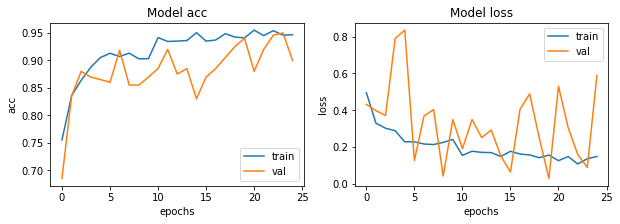

In [8]:
# Visualize Loss and Accuracy Rates
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])